### Importing necessary modules and adjust figsize

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy
import sep
from astropy.io import fits
from matplotlib import rcParams

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
data = astropy.io.fits.getdata("image.fits")

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


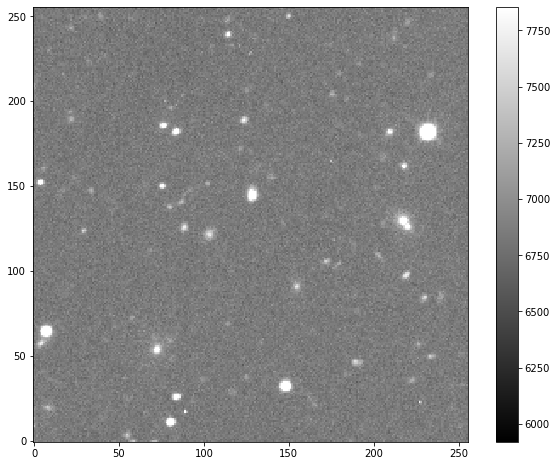

In [4]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

## Background subtraction
Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [5]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [6]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [7]:
#evaluate background as 2-d array, same size as original image
#bkg_image = bkg.back()
bkg_image = np.array(bkg)

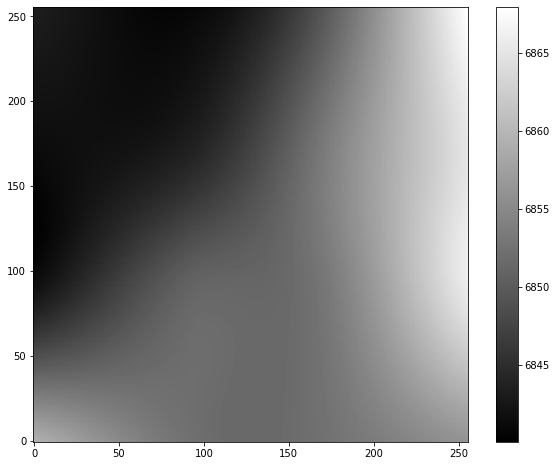

In [8]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [9]:
# evaluate the background noise as 2-D array, same size as original image
bkg_rms = bkg.rms()

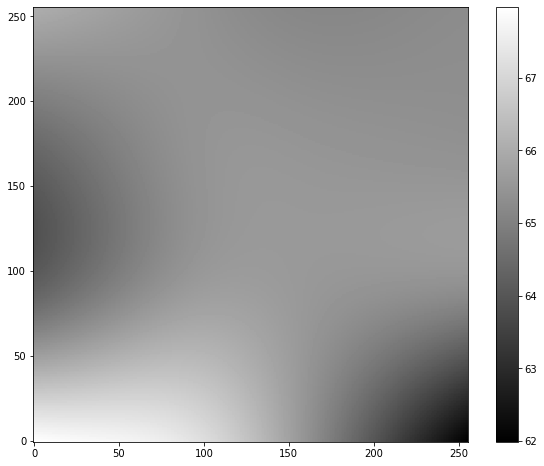

In [10]:
#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [11]:
#subtract the background
data_sub = data - bkg

^^^ you can also just use bkg.subfrom(data)

## Object detection
Now that the background is subtracted, you can run the object detection on the data. The background noise level is pretty flat, so now were going to set the detection threshold to be the constant value of 1.4(sigma) where (sigma) is our global background rms

In [12]:
objects = sep.extract(data_sub, 1.0, err=bkg.globalrms)

sep. extract has man options for controlling threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.
objects is a numpy structured array with many fields

In [13]:
#how many objects that are detected by the above by taking the length of the array
len(objects)

120

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we'll over-plot the object coordinates with some basic shape parameters ont he image:

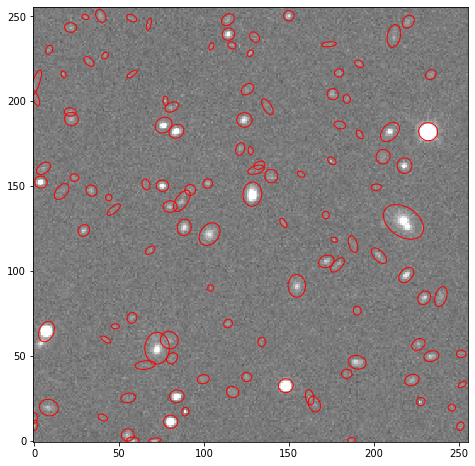

In [14]:
from matplotlib.patches import Ellipse

#plot the background subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i],objects['y'][i]),
               width=6*objects['a'][i],
               height=6*objects['b'][i],
               angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [15]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry
Finally, we'll perform simple circular aperture photometry witha  3 pixel radius at the locations of the objects:

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

flux, fluxerr and flag are all 1-D arrays with one entry per object.

In [17]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:F} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 1088.906836 +/- 295.769082
object 2: flux = 3092.220430 +/- 291.592204
object 3: flux = 5949.868379 +/- 356.562003
object 4: flux = 1435.426113 +/- 350.174271
object 5: flux = 1882.824355 +/- 296.819571
object 6: flux = 1488.554902 +/- 292.661363
object 7: flux = 1291.013887 +/- 349.477880
object 8: flux = 72688.087285 +/- 440.117338
object 9: flux = 3846.369121 +/- 354.568190
